In [229]:
import mne
import numpy as np
from scipy import io as sio, signal, stats
import matplotlib.pyplot as plt

Creating RawArray with float64 data, n_channels=66, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 100.00 Hz (-6 dB cutoff frequency: 550.00 Hz)
- Filter length: 3961 samples (3.301 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 5.00 Hz
- Up

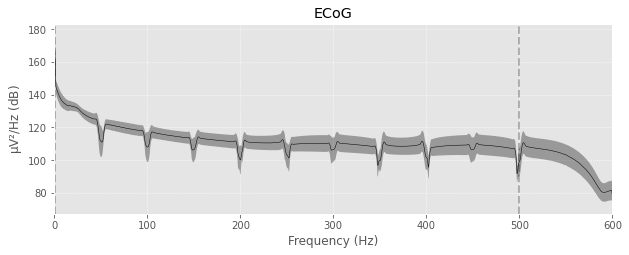

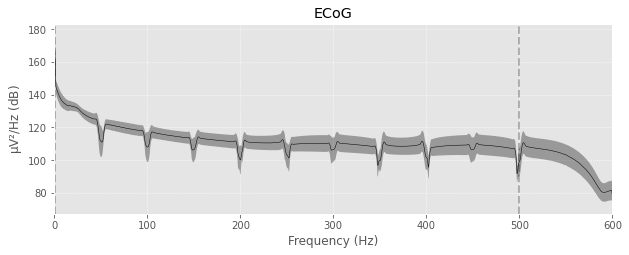

In [230]:
data = sio.loadmat('./ecog/ECoG_Handpose.mat')

sfreq = 1200.0

time = data['y'][0]
ecog = data['y'][1:61]
stim = data['y'][61:]

chan_idx = np.arange(1, ecog.shape[0] + 1)

ch_names = ['ECoG{}'.format(i) for i in chan_idx] # list of channels names
ch_names += ['gesture', 'thumb', 'index', 'middle', 'ring', 'little']
ch_types = ['ecog']*len(ecog) # list of channels types (all EEG)
ch_types += ['stim']*6

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types) # create mne info object
raw = mne.io.RawArray(data['y'][1:], info) # create mne RawArray

raw.filter(1,500)
raw.notch_filter(np.arange(50,550,50), notch_widths=2, trans_bandwidth=10)
raw.set_eeg_reference('average')
raw.plot_psd(average=True)

### MNE auto epoching (no 'rest' case)

In [231]:
events = mne.find_events(raw, stim_channel='gesture')
events_id = {'gesture1': 1, 'gesture2': 2, 'gesture3': 3}
epochs = mne.Epochs(raw, events, events_id, tmin=-0.5, tmax=2, baseline=None)

90 events found
Event IDs: [1 2 3]
Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated


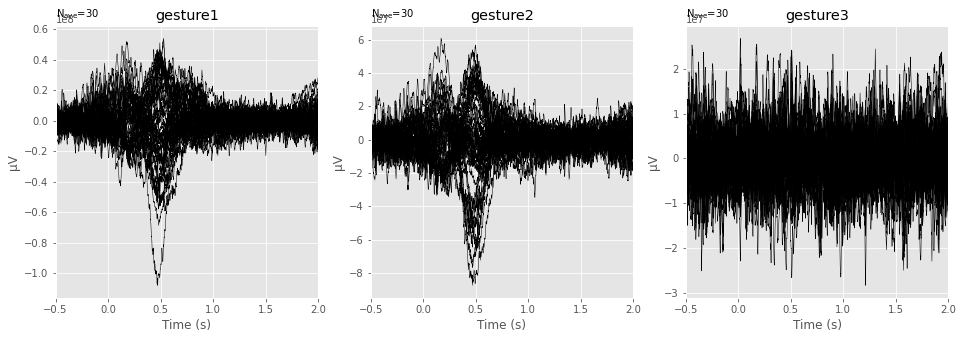

In [232]:
f, ax = plt.subplots(1,3,sharex=True, figsize=(16,5))

for a, k in zip(ax, events_id.keys()):
    epochs[k].average().plot(axes=a,show=False)
    a.set_title(k)

### Custom epoching

Text(0.5, 1.0, 'Finger data')

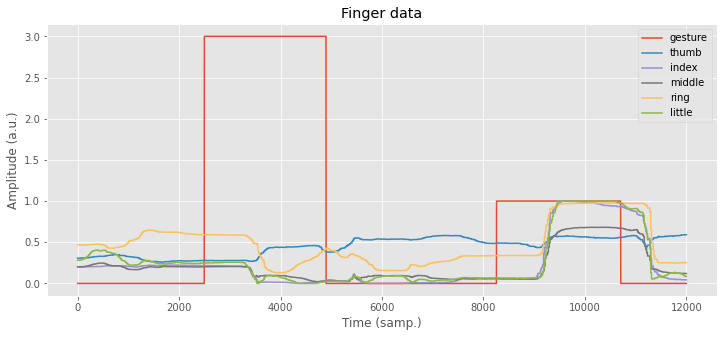

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.plot(raw.get_data()[-6:, int(10*sfreq):int(20*sfreq)].T)
plt.legend(ch_names[-6:])
plt.xlabel('Time (samp.)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Finger data')

In [78]:
trigs = np.diff(raw['gesture'][0].squeeze())

In [86]:
trigs_rest = np.where(trigs < 0)[0]
trigs_gest1 = np.where(trigs == 1)[0]
trigs_gest2 = np.where(trigs == 2)[0]
trigs_gest3 = np.where(trigs == 3)[0]

(24000.0, 48000.0)

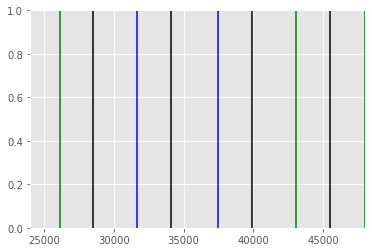

In [97]:
[plt.axvline(t, c='k') for t in trigs_rest]
[plt.axvline(t, c='r') for t in trigs_gest1]
[plt.axvline(t, c='b') for t in trigs_gest2]
[plt.axvline(t, c='g') for t in trigs_gest3]
plt.xlim(20*sfreq, 40*sfreq)

In [113]:
events = []

for i, t in enumerate([trigs_rest, trigs_gest1, trigs_gest2, trigs_gest3]):
    events.append(np.array([t, np.zeros(len(t)), i*np.ones(len(t))]).T)

events = np.vstack(events)

Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
